In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import warnings

# Установка параметров для игнорирования предупреждений
warnings.filterwarnings('ignore')

pd.set_option('display.width', 200)


In [3]:
# Загрузка данных
data = pd.read_csv('data\\train.csv')
test = pd.read_csv('data\\test.csv')

# Объединение данных
data = pd.concat([data, test], ignore_index=True)

In [4]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# Проверка пропусков по столбцам
missing_values = data.isnull().sum()

# Вывод количества пропусков по каждому столбцу
print("Количество пропусков по столбцам:")
print(missing_values)

Количество пропусков по столбцам:
PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


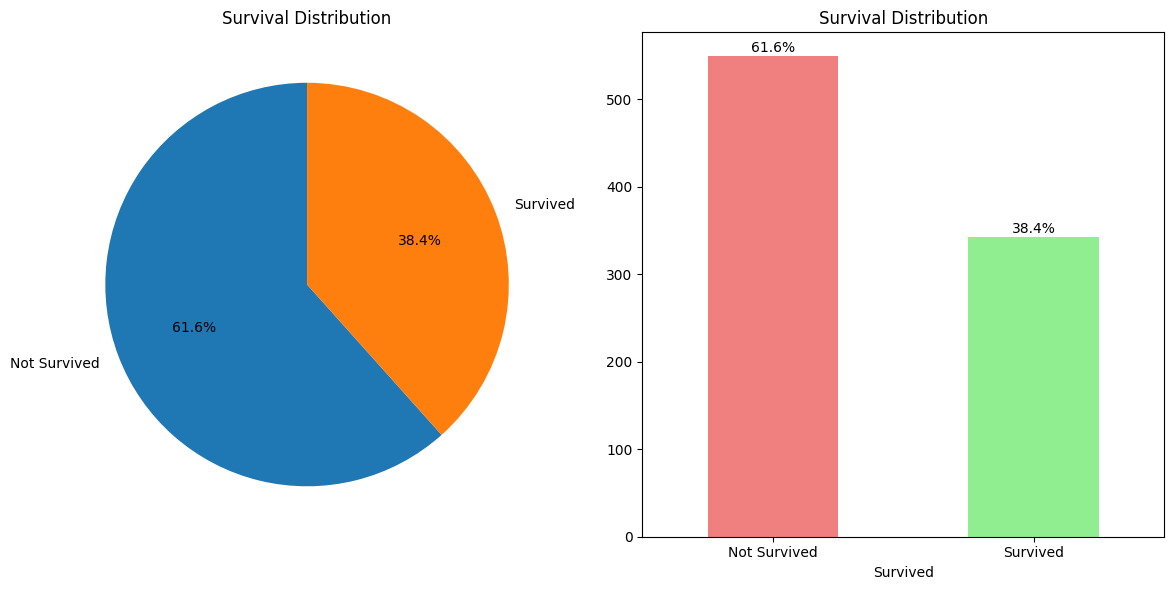

In [7]:

# Подсчет количества выживших и погибших
survived_counts = data['Survived'].value_counts()

# Создание областей для графиков
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Рисование круговой диаграммы
axes[0].pie(survived_counts, labels=['Not Survived', 'Survived'], autopct='%1.1f%%', startangle=90)
axes[0].set_title('Survival Distribution')

# Рисование столбчатой диаграммы с процентами
bar_plot = data['Survived'].value_counts().plot(kind='bar', ax=axes[1], color=['lightcoral', 'lightgreen'])
bar_plot.set_title('Survival Distribution')

# Добавление процентов на столбчатую диаграмму
totals = data['Survived'].value_counts().sum()
for p in bar_plot.patches:
    height = p.get_height()
    bar_plot.text(p.get_x() + p.get_width() / 2, height + 5, f'{height / totals:.1%}', ha='center')

bar_plot.set_xticklabels(['Not Survived', 'Survived'], rotation=0)  # Устанавливаем подписи оси x

plt.tight_layout()
plt.show()



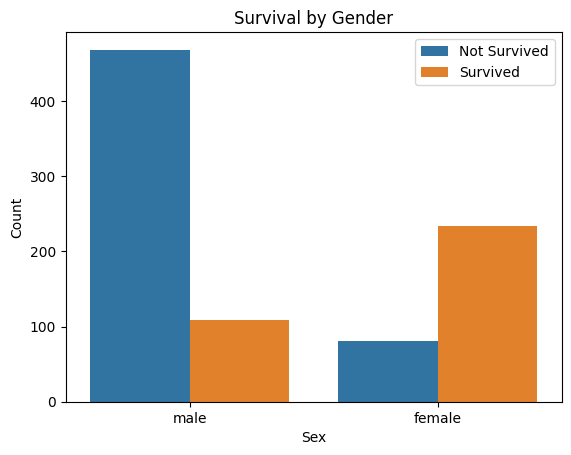

In [8]:
# Построение графика
sns.countplot(x='Sex', hue='Survived', data=data)
plt.title('Survival by Gender')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.legend(['Not Survived', 'Survived'])
plt.show()

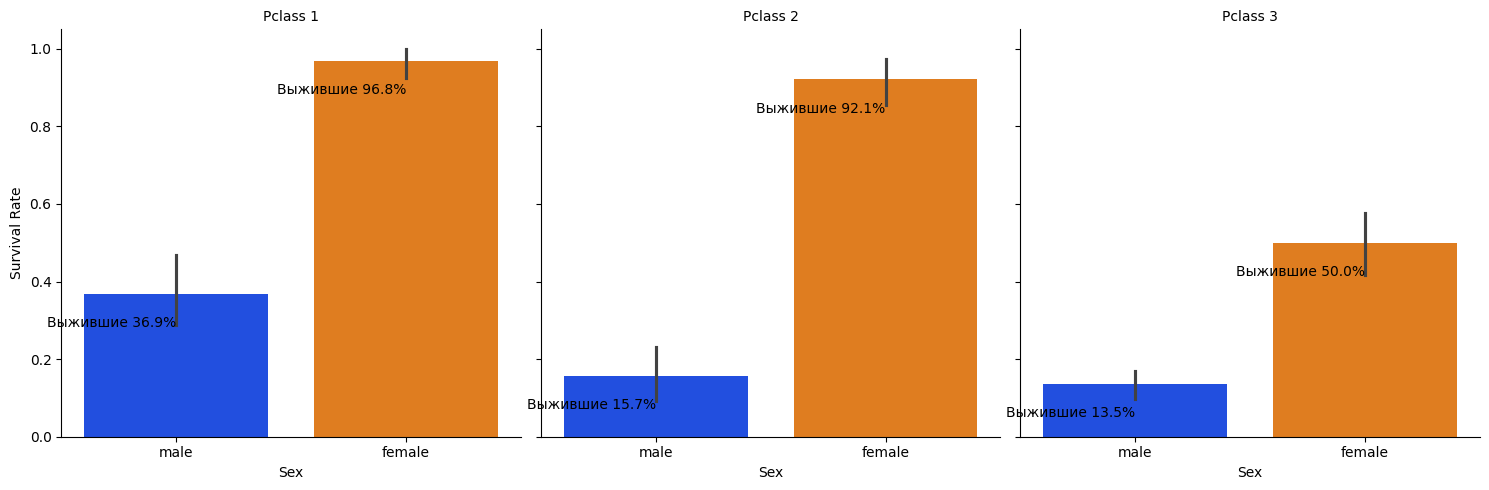

In [9]:

# Создаем график с помощью catplot
g = sns.catplot(data=data, y='Survived', x='Sex', col='Pclass', kind='bar', palette='bright')

# Настройка осей и заголовка
g.set_ylabels('Survival Rate')
g.set_xlabels('Sex')
g.set_titles(col_template='Pclass {col_name}')
plt.tight_layout()

# Добавляем проценты выживших над столбцами
for ax in g.axes.flat:
    for p in ax.patches:
        ax.annotate(f'Выжившие {p.get_height() * 100:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='right', va='center_baseline', fontsize=10, color='black', xytext=(0, -20), textcoords='offset points')

# Показываем график
plt.show()


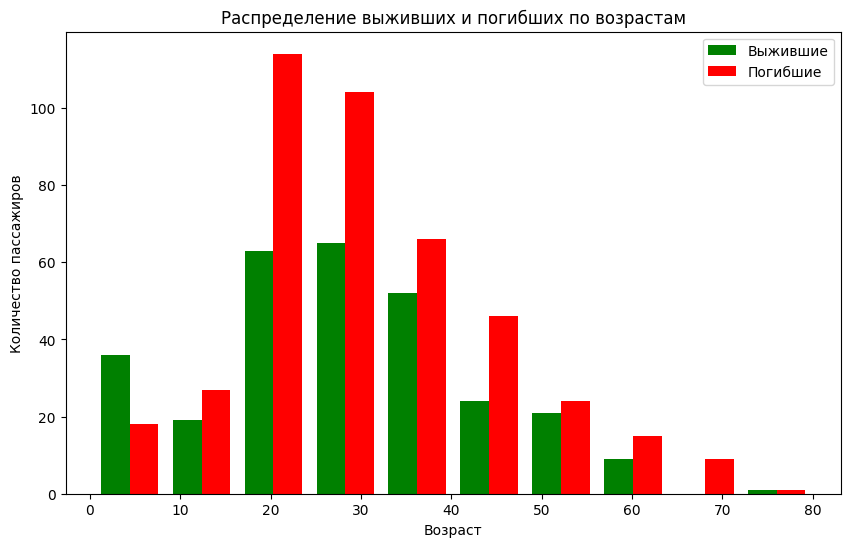

In [10]:
import matplotlib.pyplot as plt

# Разделение пассажиров на категории "выжившие" и "погибшие" по возрасту
survived_age = data[data['Survived'] == 1]['Age']
died_age = data[data['Survived'] == 0]['Age']

# Создание гистограммы
plt.figure(figsize=(10, 6))
plt.hist([survived_age, died_age], bins=10, color=['green', 'red'], label=['Выжившие', 'Погибшие'])

# Настройка графика
plt.title('Распределение выживших и погибших по возрастам')
plt.xlabel('Возраст')
plt.ylabel('Количество пассажиров')
plt.legend()

# Отображение графика
plt.show()


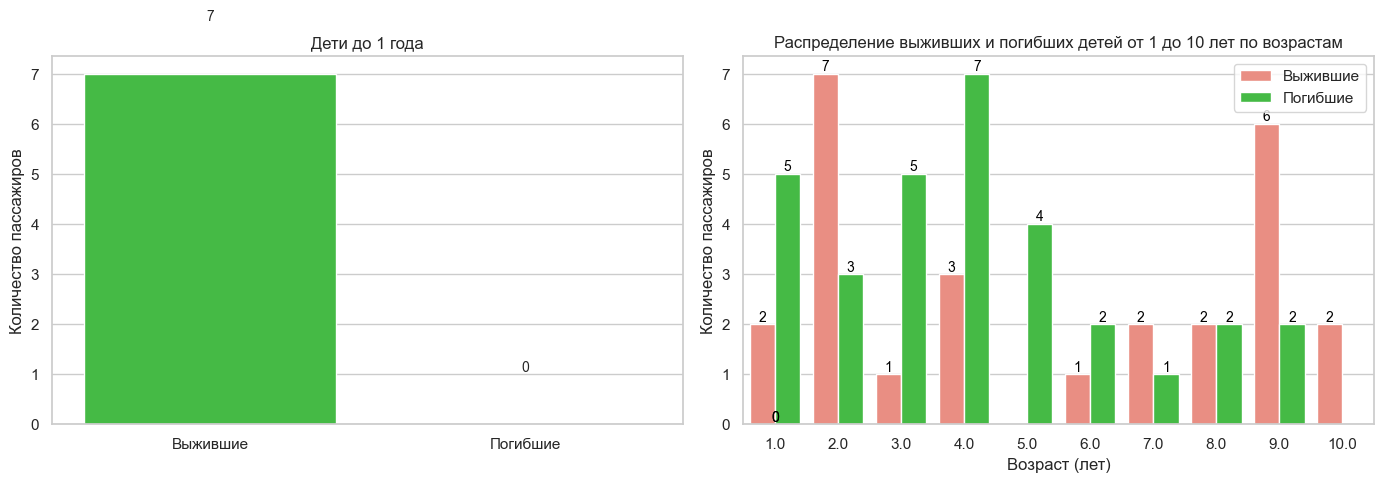

In [41]:
# Размер графика
plt.figure(figsize=(14, 5))

# График для детей до 1 года
plt.subplot(1, 2, 1)  # 1 строка, 2 столбца, первый график
sns.barplot(x=['Выжившие', 'Погибшие'], y=[len(survived_infant), len(died_infant)], palette=['limegreen', 'salmon'])
plt.title('Дети до 1 года')
plt.ylabel('Количество пассажиров')


# Добавление текста с количеством
for i, v in enumerate([len(survived_infant), len(died_infant)]):
    plt.text(i, v + 1, str(v), ha='center', va='bottom', fontsize=10)

# График для детей от 1 до 10 лет с разбивкой по годам
plt.subplot(1, 2, 2)  # 1 строка, 2 столбца, второй график
sns.countplot(data=data[(data['Age'] >= 1) & (data['Age'] <= 10)], x='Age', hue='Survived', palette=['salmon', 'limegreen'])
plt.title('Распределение выживших и погибших детей от 1 до 10 лет по возрастам')
plt.xlabel('Возраст (лет)')
plt.ylabel('Количество пассажиров')
plt.legend(['Выжившие', 'Погибшие'])

# Добавление текста с количеством
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

# Отображение графиков
plt.tight_layout()
plt.show()



In [42]:
# Количество погибших детей до 1 года
died_infant_count = len(data[(data['Survived'] == 0) & (data['Age'] < 1)])
died_child_count = len(data[(data['Survived'] == 1) & (data['Age'] < 10)])

print("Количество погибших детей до 1 года:", died_infant_count)
print("Количество погибших детей до 10 лет:", died_child_count)

Количество погибших детей до 1 года: 0
Количество погибших детей до 10 лет: 38


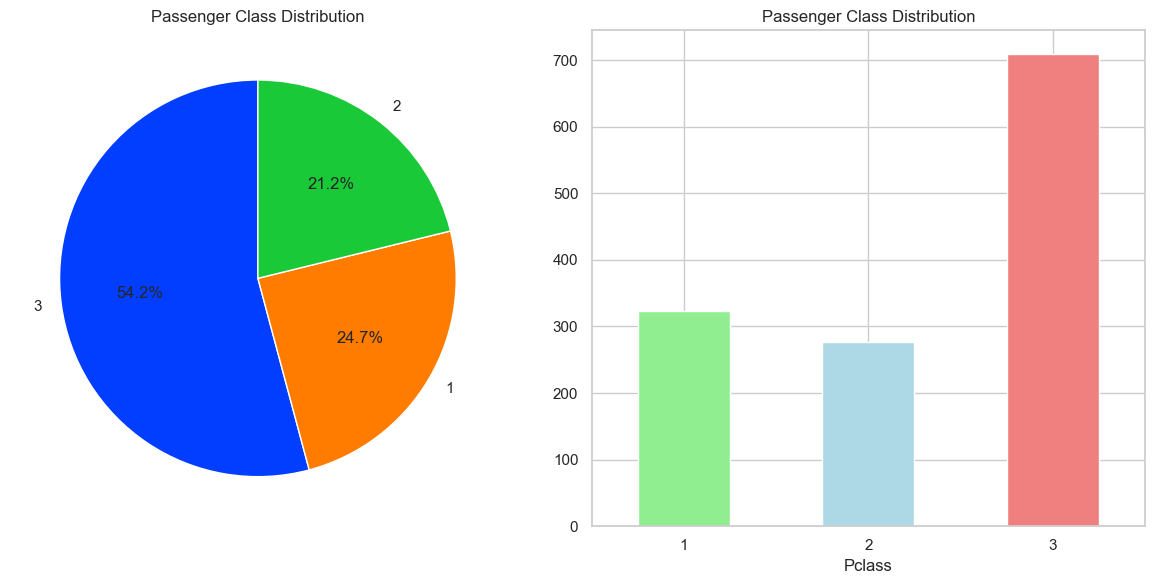

In [43]:
# Подсчет количества пассажиров по классу
class_counts = data['Pclass'].value_counts()

# Создание областей для графиков
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Рисование круговой диаграммы
axes[0].pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Passenger Class Distribution')

# Рисование столбчатой диаграммы
ordered_class_counts = class_counts.sort_index()  # Упорядочиваем значения по индексу
bar_plot = ordered_class_counts.plot(kind='bar', ax=axes[1], color=['lightgreen', 'lightblue', 'lightcoral'])
bar_plot.set_title('Passenger Class Distribution')
bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=0)  # Поворачиваем подписи горизонтально

plt.tight_layout()
plt.show()

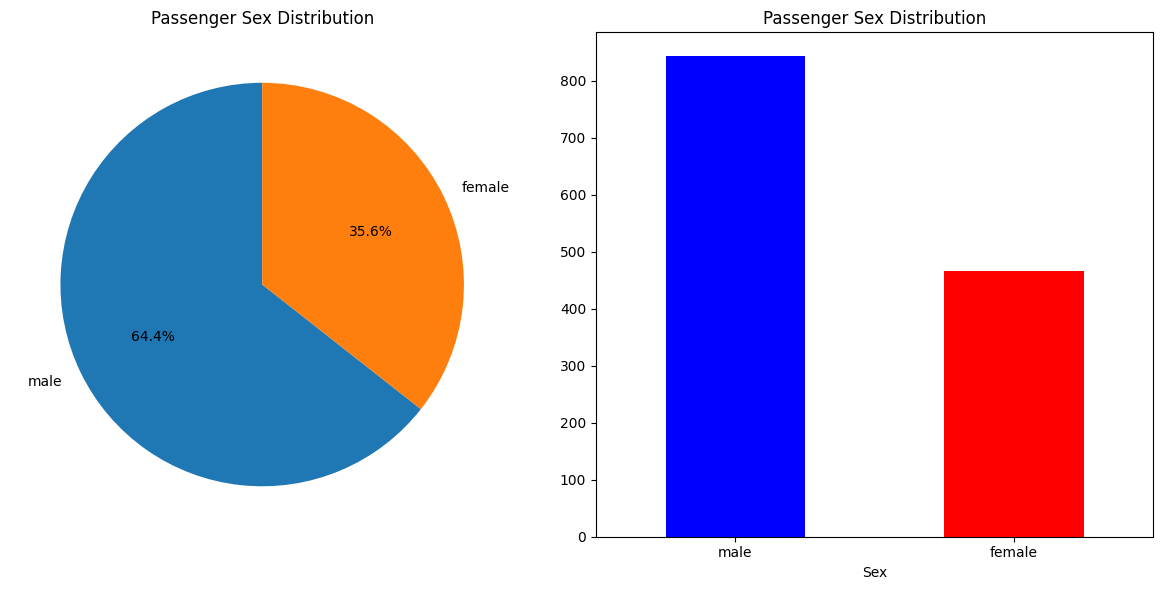

In [14]:
# Подсчет количества пассажиров по полу
sex_counts = data['Sex'].value_counts()

# Создание областей для графиков
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Рисование круговой диаграммы
axes[0].pie(sex_counts, labels=sex_counts.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Passenger Sex Distribution')

# Рисование столбчатой диаграммы
bar_plot = data['Sex'].value_counts().plot(kind='bar', ax=axes[1], color=['blue', 'red'])
bar_plot.set_title('Passenger Sex Distribution')
bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=0)  # Поворачиваем подписи горизонтально


plt.tight_layout()
plt.show()

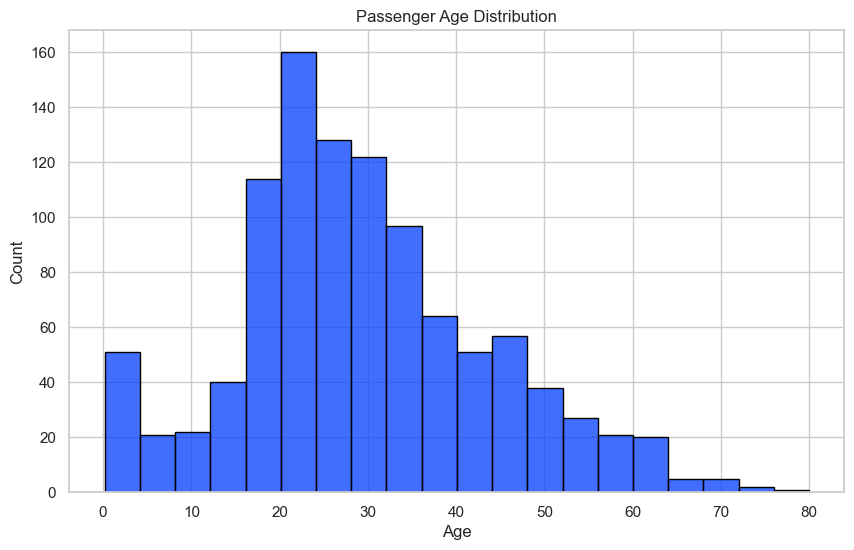

In [15]:
# Удаление пропущенных значений в столбце возраста
age_data = data['Age'].dropna()

# Настройка стиля и цветовой палитры Seaborn
sns.set(style="whitegrid", palette="bright")

# Рисование гистограммы с помощью Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(age_data, bins=20, edgecolor='black')
plt.title('Passenger Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

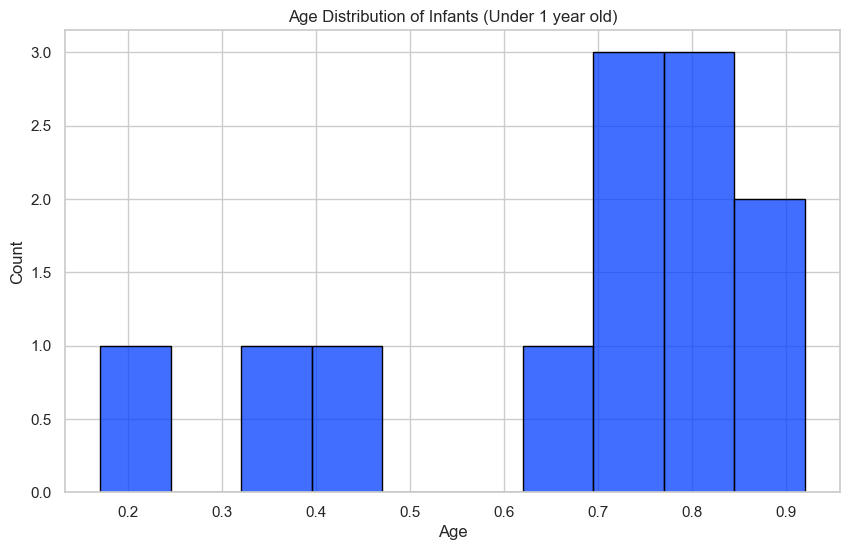

In [16]:
# Ограничение данных до возраста до 1 года
age_data_infant = data[data['Age'] < 1]['Age']

# Настройка стиля и цветовой палитры Seaborn
sns.set(style="whitegrid", palette="bright")

# Рисование гистограммы с помощью Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(age_data_infant, bins=10, edgecolor='black')
plt.title('Age Distribution of Infants (Under 1 year old)')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

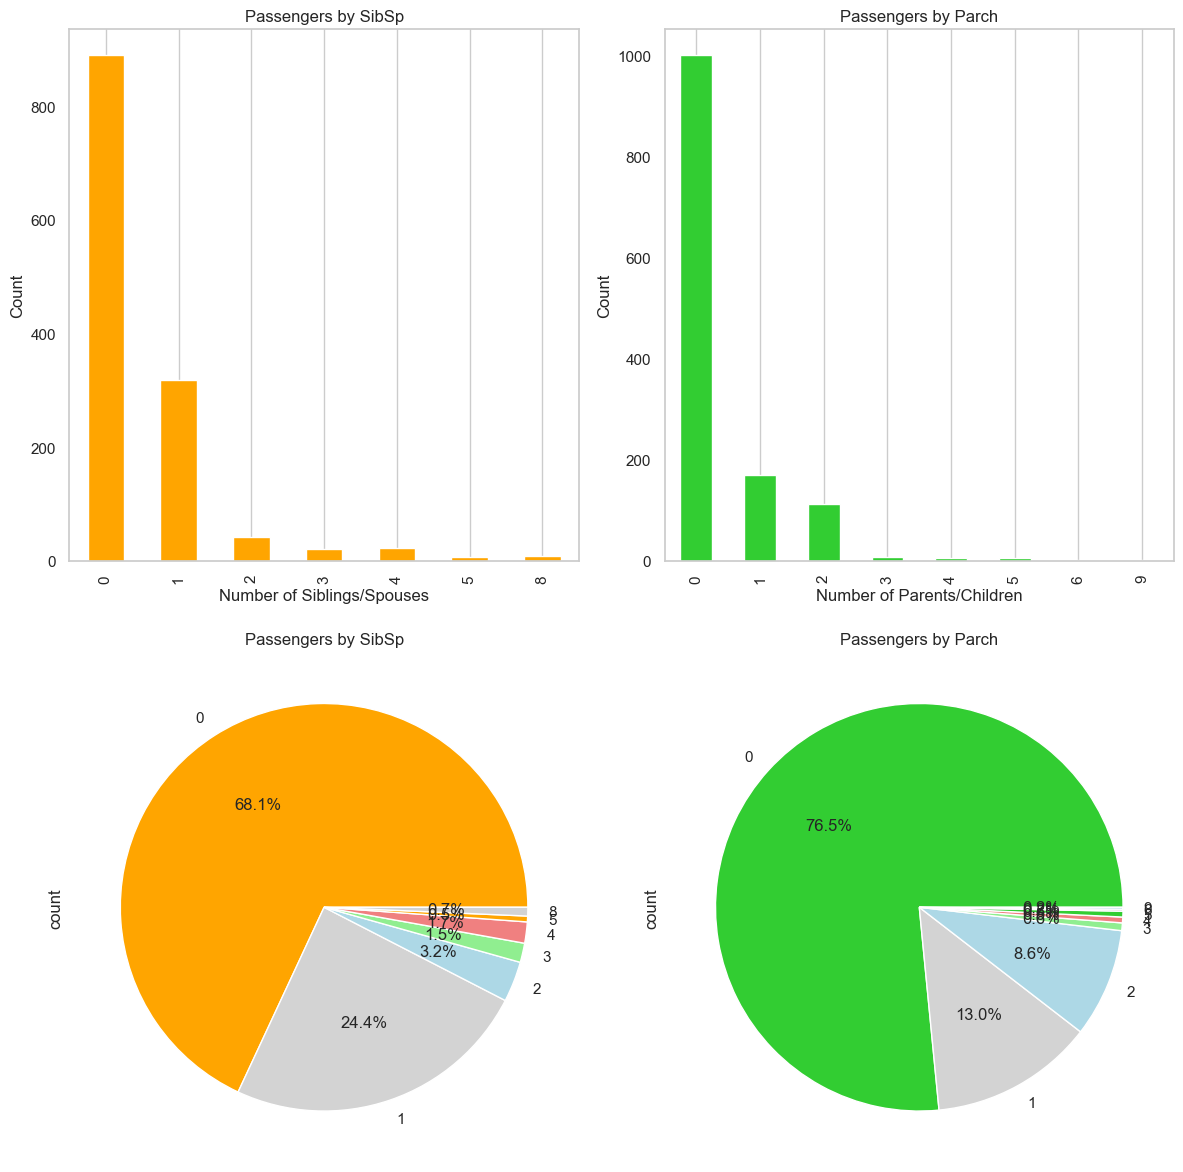

In [17]:
# Создаем фигуру и оси для двух графиков
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# График по столбцу SibSp
data['SibSp'].value_counts().sort_index().plot(kind='bar', color='orange', ax=axs[0, 0])
axs[0, 0].set_title('Passengers by SibSp')
axs[0, 0].set_xlabel('Number of Siblings/Spouses')
axs[0, 0].set_ylabel('Count')
axs[0, 0].grid(axis='y')

# График по столбцу Parch
data['Parch'].value_counts().sort_index().plot(kind='bar', color='limegreen', ax=axs[0, 1])
axs[0, 1].set_title('Passengers by Parch')
axs[0, 1].set_xlabel('Number of Parents/Children')
axs[0, 1].set_ylabel('Count')
axs[0, 1].grid(axis='y')

# Круговая диаграмма по столбцу SibSp
data['SibSp'].value_counts().sort_index().plot(kind='pie', ax=axs[1, 0], colors=['orange', 'lightgray', 'lightblue', 'lightgreen', 'lightcoral'], autopct='%1.1f%%')
axs[1, 0].set_title('Passengers by SibSp')

# Круговая диаграмма по столбцу Parch
data['Parch'].value_counts().sort_index().plot(kind='pie', ax=axs[1, 1], colors=['limegreen', 'lightgray', 'lightblue', 'lightgreen', 'lightcoral'], autopct='%1.1f%%')
axs[1, 1].set_title('Passengers by Parch')

# Показываем графики
plt.tight_layout()
plt.show()



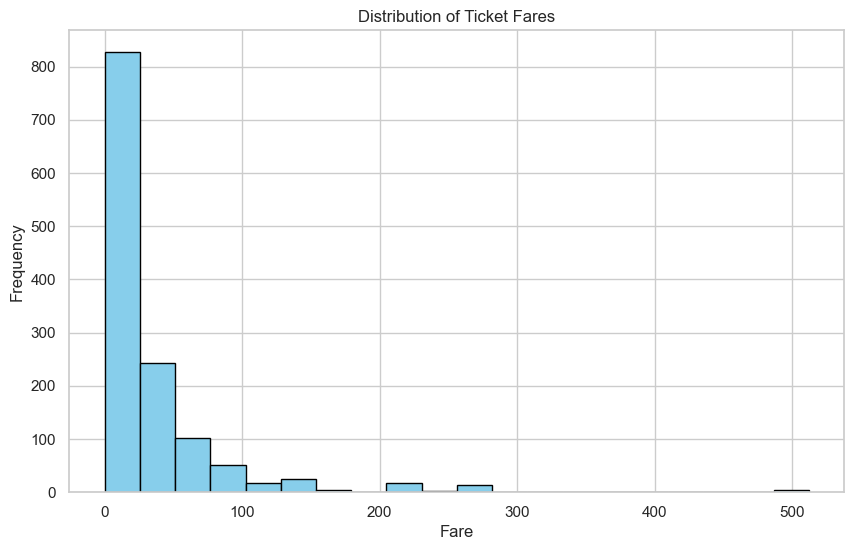

In [18]:
# Получение данных о стоимости билетов
fare_data = data['Fare']

# Построение гистограммы распределения цен билетов
plt.figure(figsize=(10, 6))
plt.hist(fare_data, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Ticket Fares')
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


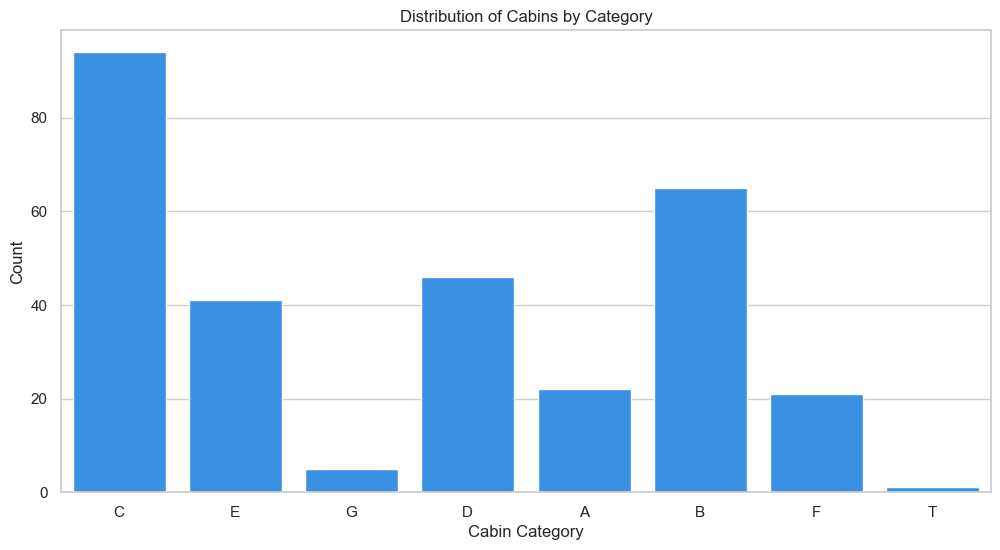

In [19]:
# Удаление пропущенных значений в столбце 'Cabin'
data_cabin = data['Cabin'].dropna()

# Создание столбчатой диаграммы для распределения кабин по категориям
plt.figure(figsize=(12, 6))
sns.countplot(x=data_cabin.str[0], color='dodgerblue')

plt.title('Distribution of Cabins by Category')
plt.xlabel('Cabin Category')
plt.ylabel('Count')

# Поворот подписей абсциссы
plt.xticks(rotation=0)

plt.show()


A: кабины на верхних палубах, ближе к носу судна.  
B: также кабины на верхних палубах, но расположены немного ниже, обычно ближе к центру судна.  
C: кабины на центральных палубах, вблизи ресторанов и общественных помещений.  
D: кабины на средних палубах, обычно ближе к корме судна.  
E: кабины на нижних палубах, но все еще находятся выше ватерлинии.  
F и G: кабины на самых нижних палубах, ближе к воде.  

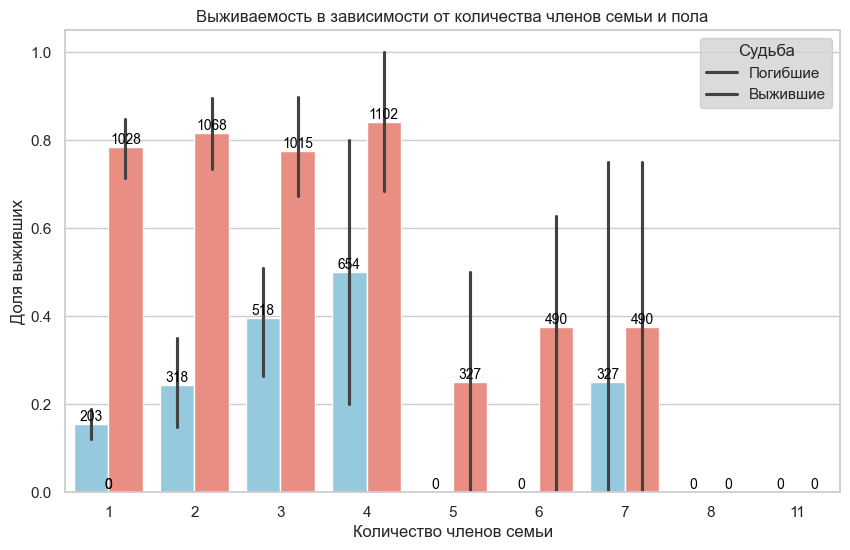

In [48]:
# Добавление столбца с общим количеством членов семьи
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

# Создание графика
plt.figure(figsize=(10, 6))
sns.barplot(data=data, x='FamilySize', y='Survived', hue='Sex', palette=['skyblue', 'salmon'])

# Добавление текста с количеством
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height() * len(data))}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

# Настройка графика
plt.title('Выживаемость в зависимости от количества членов семьи и пола')
plt.xlabel('Количество членов семьи')
plt.ylabel('Доля выживших')
plt.legend(title='Судьба', labels=['Погибшие', 'Выжившие'], facecolor='lightgrey')

# Отображение графика
plt.show()


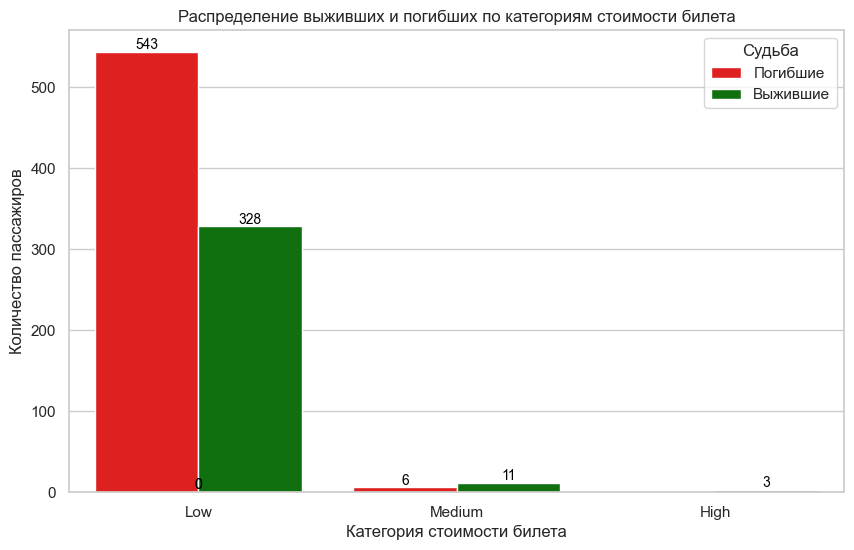

In [52]:
# Разделение столбца "Fare" на 3 категории
data['Fare_Category'] = pd.cut(data['Fare'], bins=3, labels=['Low', 'Medium', 'High'])

# Создание графика
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=data, x='Fare_Category', hue='Survived', palette=['red', 'green'])

# Добавление текста с количеством пассажиров
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

# Настройка графика
plt.title('Распределение выживших и погибших по категориям стоимости билета')
plt.xlabel('Категория стоимости билета')
plt.ylabel('Количество пассажиров')
plt.legend(title='Судьба', labels=['Погибшие', 'Выжившие'])

# Отображение графика
plt.show()

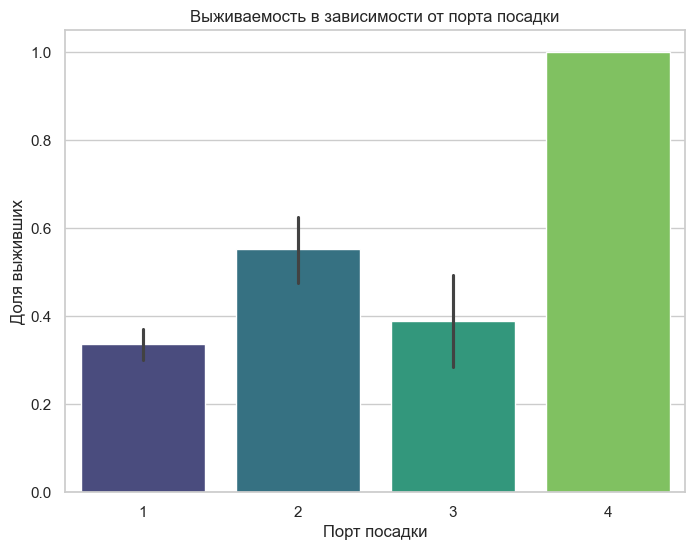

In [53]:
# Создаем график
plt.figure(figsize=(8, 6))
sns.barplot(data=data, x='Embarked', y='Survived', palette='viridis')

# Настройка графика
plt.title('Выживаемость в зависимости от порта посадки')
plt.xlabel('Порт посадки')
plt.ylabel('Доля выживших')

# Отображение графика
plt.show()
